# <font color='#4C6FF3'>Backtesting for Algorithmic Bitcoin Trading</font>

In [36]:
# Suppress runtime warnings
# import warnings
# warnings.simplefilter(action = "ignore", category = RuntimeWarning)

# Suppress all warnings
# import warnings
# warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
import numpy as np, pandas as pd, datetime 
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
from sqlalchemy import create_engine, MetaData, Table
from sqlalchemy.sql import select
from fbprophet import Prophet
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

In [3]:
passwd = '<password>' 
ec2dns = '<EC2 DNS>' 

In [9]:
def mysql_conn(passwd, ec2dns):
    '''
    Connects to MySQL database
    Returns connection object  
    '''
    db_uri = 'mysql+pymysql://' + passwd + ec2dns
    engine = create_engine(db_uri)                                                                                                                    
    meta = MetaData()                                                           
    meta.reflect(bind=engine)                                                   
    conn = engine.connect()
    return conn


def get_bpi():
    '''
    Returns Bitcoin Price Index as DataFrame
    '''
    conn = mysql_conn(passwd, ec2dns)
    bpi = pd.read_sql('''SELECT * FROM coindsk_bpi''', conn)
    bpi.date = pd.to_datetime(bpi.date)
    bpi.btc_usd_rate = pd.to_numeric(bpi.btc_usd_rate)
    b = bpi[['date', 'btc_usd_rate']]
    b.columns = ['ds', 'y']
    return b


def smp_mov_avg(values, window):
    '''
    Calculates Simple Moving Averages
    '''
    weights = np.repeat(1.0, window) / window  
    smas = list(np.convolve(values, weights, 'valid'))
    [smas.insert(0, None) for i in range(len(values) - len(smas))]
    return smas


def exp_mov_avg(values, window):
    '''
    Calculates Exponential Moving Averages
    '''
    weights = np.exp(np.linspace(-1.0, 0.0, window))
    weights /= weights.sum()
    emas = np.convolve(values, weights)[:len(values)]
    emas[:window] = emas[window]
    return emas


def get_mov_avgs(short_window=0, long_window=0, bktst_start='2016-01-01'):
    '''
    Returns Bitcoin BPI, EMAs, SMAs from `bktst_start` date to present as DataFrame
    '''
    conn = mysql_conn(passwd, ec2dns)
    bpi = pd.read_sql('''SELECT * FROM coindsk_bpi''', conn)
    bpi.date = pd.to_datetime(bpi.date)
    bpi.btc_usd_rate = pd.to_numeric(bpi.btc_usd_rate)
    bpi['ema_short'] = exp_mov_avg(bpi.btc_usd_rate, short_window)
    bpi['ema_long']  = exp_mov_avg(bpi.btc_usd_rate, long_window)
    bpi['sma_short'] = smp_mov_avg(bpi.btc_usd_rate, short_window)
    bpi['sma_long']  = smp_mov_avg(bpi.btc_usd_rate, long_window)
    mas = bpi[bpi.date >= bktst_start]  
    return mas


def predict_prophet(bktst_start=None):
    '''
    Calculates Bitcoin price for next 365 days
    Calls get_bpi() function
    '''
    bpi = get_bpi() 
    # Train on data before 1/1/2016
    bpi_thru_2015 = bpi[bpi.ds <= '2015-12-31']  
    m = Prophet()
    m.fit(bpi_thru_2015)
    days_btwn = datetime.datetime.today() - \
                datetime.datetime.strptime(bktst_start , '%Y-%m-%d')
    # Adds 30 days to allow calculation of 3, 7, 10, and 30 day forecasts
    days_btwn += datetime.timedelta(days=30)
    future = m.make_future_dataframe(periods=days_btwn.days)
    forecast = m.predict(future)
    return forecast


def get_predictors(training_end_date=False):
    '''
    Queries MySQL to get Quandl Blockchain, Mining, and Market data  
    Creates features/predictors/X
    Returns 1) predictors/X, 2) target/y, and 3) DataFrame comprised of both X and y
    '''
    conn = mysql_conn(passwd, ec2dns) # Connect to MySQL database
    bpi  = pd.read_sql('''SELECT * FROM coindsk_bpi''', conn)     # Bitcoin Price Index
    mng  = pd.read_sql('''SELECT * FROM qdl_mining_data''', conn) # Quandl Mining Data
    qmkt = pd.read_sql('''SELECT * FROM qdl_mkt_data''', conn)    # Quandl Market Data
    
    bpi.date         = pd.to_datetime(bpi.date)
    bpi.btc_usd_rate = pd.to_numeric(bpi.btc_usd_rate)

    mng.tot_blkchn_size = pd.to_numeric(mng.tot_blkchn_size)
    mng.avg_blk_size    = pd.to_numeric(mng.avg_blk_size)
    mng.tot_output_vol  = pd.to_numeric(mng.tot_output_vol)
    mng.hash_rate_btc   = pd.to_numeric(mng.hash_rate_btc)
    mng.miners_rev      = pd.to_numeric(mng.miners_rev)
    mng.difficulty      = pd.to_numeric(mng.difficulty)
    mng.date            = pd.to_datetime(mng.date)
    qmkt.date                 = pd.to_datetime(qmkt.date)
    qmkt.tot_BTCs             = pd.to_numeric(qmkt.tot_BTCs)
    qmkt.btc_mkt_cap          = pd.to_numeric(qmkt.btc_mkt_cap)
    qmkt.tot_btc_addrs        = pd.to_numeric(qmkt.tot_btc_addrs)
    qmkt.btc_trans_vol        = pd.to_numeric(qmkt.btc_trans_vol)
    qmkt.btc_exch_trade_vol   = pd.to_numeric(qmkt.btc_exch_trade_vol)
    qmkt.btc_num_trans        = pd.to_numeric(qmkt.btc_num_trans)
    qmkt.btc_tot_trans        = pd.to_numeric(qmkt.btc_tot_trans)
    qmkt.trans_less_pop_addrs = pd.to_numeric(qmkt.trans_less_pop_addrs)
    qmkt.trans_per_blk        = pd.to_numeric(qmkt.trans_per_blk)
    qmkt.avg_trans_conf_time  = pd.to_numeric(qmkt.avg_trans_conf_time)
    qmkt.tot_trans_fees_btc   = pd.to_numeric(qmkt.tot_trans_fees_btc)
    qmkt.tot_trans_fees_usd   = pd.to_numeric(qmkt.tot_trans_fees_usd)
    qmkt.cost_per_trans       = pd.to_numeric(qmkt.cost_per_trans)
    qmkt.cost_as_perct_vol    = pd.to_numeric(qmkt.cost_as_perct_vol)
    
    # Merge DataFrames
    dfs = [bpi, mng, qmkt]
    df = reduce(lambda df1, df2: pd.merge(df1, df2, on='date'), dfs)
    df = df.set_index('date') 
    del df.index.name
    
    # Create target to predict
    y = df.btc_usd_rate
    
    # Add BTC_USD price for previous 5 days
    df['btc_usd_lag1'] = df.btc_usd_rate.shift(periods=1, freq=None, axis='index') # 1 day before 
    df['btc_usd_lag2'] = df.btc_usd_rate.shift(periods=2, freq=None, axis='index') # 2 days before
    df['btc_usd_lag3'] = df.btc_usd_rate.shift(periods=3, freq=None, axis='index') # 3 days
    df['btc_usd_lag4'] = df.btc_usd_rate.shift(periods=4, freq=None, axis='index') # 4 days
    df['btc_usd_lag5'] = df.btc_usd_rate.shift(periods=5, freq=None, axis='index') # 5 days
    
    # Shift 'btc_usd_rate' so that we are predicting the next day's rate not the current day's rate
    df.btc_usd_rate = df.btc_usd_rate.shift(-1)
    
    # Create predictors; remove 'residuals', 'timestp', and y 
    X = df[[col for col in list(df.columns) if  not col == 'residuals'\
                                            and not col == 'btc_usd_rate'\
                                            and not col == 'timestp']]
    
    # Delete first 4 rows of X to eliminate NaNs
    X = X[X.index > (X.index.min() + datetime.timedelta(days=4))]
    
    # Delete first 4 rows of y so X and y align properly
    y = y[y.index > (y.index.min() + datetime.timedelta(days=4))]
    
    # Eliminate X and y values after `training_end_date` to prevent data leakage
    # Each day, the model is trained on an additional row of data representing the 
    # .. previous day. Data is scraped and written to MySQL nightly.
    X = X[X.index < training_end_date]
    y = y[y.index < training_end_date]
    
    return X, y, df


def get_reg_regr_predictions(training_end_date=False):
    '''
    Returns models, predictions from training, and corresponding R-squared scores
    '''
    X, y, df = get_predictors(training_end_date=training_end_date)
    
    # Get predictors for each day of the backtest (set by user in `bktst_start`)
    daily_predictors = df[df.index >= training_end_date]
    
    train_size = int(len(X) * 0.66) # Split data into train and test sets
    y_train, y_test = y[1:train_size], y[train_size:]
    X_train, X_test = X[1:train_size], X[train_size:]
    
    # Instantiate estimators
    olsr = LinearRegression()
    rdge = Ridge()
    lsso = Lasso()
    lscv = LassoCV()
    
    # Fit estimators
    olsr.fit(X_train, y_train)
    rdge.fit(X_train, y_train)
    lsso.fit(X_train, y_train)
    lscv.fit(X_train, y_train)
    
    predictions = dict()
    r2_scores   = dict()
    
    predictions['OLSR'] = olsr.predict(X_test)
    predictions['RDGE'] = rdge.predict(X_test)
    predictions['LSSO'] = lsso.predict(X_test)
    predictions['LSCV'] = lscv.predict(X_test)
    
    r2_scores['OLSR'] = olsr.score(X_test[:-1], y_test[:-1]) # Keep out last val (NaN b/c it's not yet known)
    r2_scores['RDGE'] = rdge.score(X_test[:-1], y_test[:-1])
    r2_scores['LSSO'] = lsso.score(X_test[:-1], y_test[:-1])
    r2_scores['LSCV'] = lscv.score(X_test[:-1], y_test[:-1])
    
    return olsr, rdge, lsso, lscv, predictions, r2_scores, daily_predictors, df


def ema_backtest(bktst_start=False, # Date at which to start the backtest
                 start_btc=0,       # Number of Bitcoins to start 
                 start_usd=0,       # $ USD to start
                 margin=False,      # If "True", keeps trading if portfolio < $0 (accrues liability)
                 short_window=60,   # Short window for EMA crossover; 60 by default
                 long_window=10,    # Long window for  EMA crossover; 10 by default
                 max_trade=10,      # Max Bitcoin to BUY or SELL; 10 by default
                 verbose=False):    # If "True", prints daily stats 
    '''
    Executes EMA backtest with `short_window` and `long_window` specified by the user
    Returns DataFrames of all trades executed, all predictions and errors, and training data 
    '''
  
    # Get Prophet predictions 
    ps = predict_prophet(bktst_start=bktst_start) 
    
    # Get Moving Averages (EMAs and SMAs)
    mov_avgs = get_mov_avgs(short_window=short_window, long_window=long_window)

    # Ensure that "mov_avgs" is  same length as "daily_predictors""
    mov_avgs[mov_avgs.date >= bktst_start]  
    
    # Zip back into lists for iteration via `for` loop below
    mov_avgs = zip(list(mov_avgs.ema_short), list(mov_avgs.ema_long), list(mov_avgs.date), 
                   list(mov_avgs.btc_usd_rate), list(mov_avgs.sma_short), list(mov_avgs.sma_long))
    
    # Day before backtesting start date
    start_date = mov_avgs[0][2] - datetime.timedelta(days=1) 
    
    # Tracks current Portfolio value only
    # For display only! For all portfolio info for all dates, see 'trades' DataFrame 
    portfolio = {'DATE': start_date, 'BTC': start_btc, 'USD': start_usd}
    
    # If verbose is True, display initial portfolio
    if verbose:
        print 'Initial Portfolio:\n', portfolio
    
    # Tracks ALL Trades
    trade_hist = dict()
    trade_hist[start_date] = {'BTC': start_btc, 
                              'USD': start_usd, 
                              'TOT': start_usd + (start_btc * mov_avgs[0][3]),
                              'DIF': 0,
                              'TYP': 'OPN',
                              'QTY': 0, 
                              'BTC_USD': mov_avgs[0][3]}
    
    # Display initial (empty) trade history
    if verbose:
        print '\nInitial Trade History:\n', trade_hist
    
    # To hold daily predictions from regularized regression models
    daily_regr_predicts = dict()
    
    # To hold Prophet forecasts
    prophet_fcasts = dict()
    
    # To hold daily variance in BTC_USD rate
    daily_btc_variance = dict()
    
    # Initial val for inter-day BTC Exchange trade volume
    yestrday_btc_usd_vol = 1
    
    # To hold inter-day BTC Exchange trade volume data
    dailyBTCUSDexch_vol = dict()
    
    # To hold MAE for Regularized Regression and Prophet predictions
    daily_errs = dict()
    
    # The inter-day variance in BTC_USD (i.e., day-to-day, not during the day)
    daily_btc_usd_variance = 1

    # Use actual value of Bitcoin Price Index ("BPI")  
    daily_regr_mean = mov_avgs[0][3]
    
    # Initial values for BTC-USD rate to compare each day with previous day  
    yestr_btcusdr = mov_avgs[0][3] 
    
    # To hold EMA differences
    ema_diffs = dict()
    
    # For each day since "bktst_start" ...
    for i, (ema_s, ema_l, btcd, btcusdr, sma_s, sma_l) in enumerate(mov_avgs):
        
        # Reset diff (if no trades today, would keep previous day's diff as today's diff)  
        diff = 0
        
        # Increment training end date to add previous day to training data each day
        training_end_date = datetime.datetime.strptime(bktst_start, '%Y-%m-%d') + datetime.timedelta(days=i) 
        
        # Get Predictors (OLSR, Ridge, Lasso, LassoCV)
        olsr, rdge, lsso, lscv, predictions, r2_scores, daily_predictors, X_train_test_df = \
        get_reg_regr_predictions(training_end_date=training_end_date)
        
        # Daily Predictions: Regularized Regression
        tday = daily_predictors[daily_predictors.index == btcd]
         
        # Rename column 'btc_usd' to 'actual_nxt_day_btc_usd' to reflect that is the 
        # ... ground truth for the predictors in the same row
        tday.rename(columns={'btc_usd_rate': 'actual_nxt_day_btc_usd'}, inplace=True)
        
        # If no predictors/data for today, move on to the next day
        if tday.empty:
            continue
        
        # Extract Daily Exchange Volume for Today
        tday_btc_usd_volume = tday[tday.index == btcd].btc_exch_trade_vol  
        
        # Extract Daily Exchange Volume for Prior Week, Month, Quarter, and Year
        date_one_year_ago = btcd - datetime.timedelta(days=365)
        date_one_qrtr_ago = btcd - datetime.timedelta(days=91)
        date_one_mnth_ago = btcd - datetime.timedelta(days=30)
        date_one_week_ago = btcd - datetime.timedelta(days=7)
        
        X_year = X_train_test_df[X_train_test_df.index >= date_one_year_ago].btc_exch_trade_vol
        X_qrtr = X_train_test_df[X_train_test_df.index >= date_one_qrtr_ago].btc_exch_trade_vol
        X_mnth = X_train_test_df[X_train_test_df.index >= date_one_mnth_ago].btc_exch_trade_vol
        X_week = X_train_test_df[X_train_test_df.index >= date_one_week_ago].btc_exch_trade_vol
    
        # Convert `tday_btc_usd_volume` and `yestrday_btc_usd_vol` to integers
        # If any missing values, use prior day's volume
        try:
            tday_btc_usd_volume = float(tday_btc_usd_volume.values)
        except TypeError as e: 
            print e
            tday_btc_usd_volume = yestrday_btc_usd_vol   
        yestrday_btc_usd_vol = float(yestrday_btc_usd_vol)
    
        # Add today's BTC_USD exchange volume
        dailyBTCUSDexch_vol[btcd] = tday_btc_usd_volume
        
        # The inter-day variance in BTC_USD (i.e., day-to-day, not during the day)
        daily_btc_usd_variance = (yestr_btcusdr - btcusdr) / btcusdr
    
        # To hold daily variance in BTC_USD rate
        daily_btc_variance[btcd] = daily_btc_usd_variance
            
        # Capture current `btcusdr` for comparison with next day's `btcusdr`
        yestr_btcusdr = btcusdr

        # Extract the date, timestamp, errors, and historic BPI)
        # Save to new DataFrame that does not leak 'actual_nxt_day_btc_usd' when backtesting
        tdays_p = tday[[col for col in list(tday.columns) if  not col == 'residuals'\
                                                          and not col == 'actual_nxt_day_btc_usd'\
                                                          and not col == 'date'\
                                                          and not col == 'timestp']]
        
        # Create dictionary of dictionaries for plotting daily predictions
        daily_regr_predicts[btcd] = {'OLSR': round(float(olsr.predict(tdays_p)), 2),
                                     'RDGE': round(float(rdge.predict(tdays_p)), 2),
                                     'LSSO': round(float(lsso.predict(tdays_p)), 2),
                                     'LSCV': round(float(lscv.predict(tdays_p)), 2),
                                     'BTC_USD': btcusdr} 
        
        # Capture yesterday's prediction for BUY/SELL decisions
        yestr_reg_mean = daily_regr_mean 
        
        # Calculate mean of daily predictions as an Ensemble prediction
        daily_regr_mean = round(np.mean([daily_regr_predicts[btcd]['OLSR'], 
                                         daily_regr_predicts[btcd]['RDGE'], 
                                         daily_regr_predicts[btcd]['LSSO'],
                                         daily_regr_predicts[btcd]['LSCV']]), 2)
        
        # Calculate absolute $ and % change for use in making predictions below
        reg_mean_diff     = daily_regr_mean - yestr_reg_mean
        reg_mean_diff_pct = (reg_mean_diff   / yestr_reg_mean) * 100
        
        # Calculate Prophet 3, 7, 10, and 30 day forecasts
        three_d_proph  = btcd + datetime.timedelta(days=3)
        seven_d_proph  = btcd + datetime.timedelta(days=7)
        ten_d_proph    = btcd + datetime.timedelta(days=10)
        thirty_d_proph = btcd + datetime.timedelta(days=30)
        
        proph_fcast3   = round(ps[ps.ds == three_d_proph.date()].yhat.values[0], 2)
        proph_fcast7   = round(ps[ps.ds == seven_d_proph.date()].yhat.values[0], 2)
        proph_fcast10  = round(ps[ps.ds == ten_d_proph.date()].yhat.values[0], 2)
        proph_fcast30  = round(ps[ps.ds == thirty_d_proph.date()].yhat.values[0], 2)
        
        # Extract Today's Prophet BTC price prediction
        today_proph_p = round(ps[ps.ds == btcd].yhat.values[0], 2)      # Current day
        
        # Absolute and % change for forecasts
        yestr_proph_p = round(ps[ps.ds == btcd - datetime.timedelta(days=1)].yhat.values[0], 2) # Day before (for comparison w/ predictions)
    
        # Extract `yhat_upper` and `yhat_lower` from FBProphet DataFrame
        fbp_yhat_upr = round(ps[ps.ds == btcd].yhat_upper.values[0], 2) # Current day 
        fbp_yhat_low = round(ps[ps.ds == btcd].yhat_lower.values[0], 2) # Current day
        
        fcast_chg3  = proph_fcast3  - today_proph_p
        fcast_chg7  = proph_fcast7  - today_proph_p
        fcast_chg10 = proph_fcast10 - today_proph_p
        fcast_chg30 = proph_fcast30 - today_proph_p
        
        fcast_pct_chg3  = round((fcast_chg3  / today_proph_p) * 100, 2)
        fcast_pct_chg7  = round((fcast_chg7  / today_proph_p) * 100, 2)
        fcast_pct_chg10 = round((fcast_chg10 / today_proph_p) * 100, 2)
        fcast_pct_chg30 = round((fcast_chg30 / today_proph_p) * 100, 2)
        
        # Create dictionary of dictionaries for plotting daily forecasts
        prophet_fcasts[btcd] = {'3-day': proph_fcast3,
                                '7-day': proph_fcast7,
                                '10day': proph_fcast10,
                                '30day': proph_fcast30}
        
        # Calculate Residuals for daily predictions 
        err_olsr = np.abs(tday.actual_nxt_day_btc_usd - daily_regr_predicts[btcd]['OLSR'])
        err_rdge = np.abs(tday.actual_nxt_day_btc_usd - daily_regr_predicts[btcd]['RDGE']) 
        err_lsso = np.abs(tday.actual_nxt_day_btc_usd - daily_regr_predicts[btcd]['LSSO']) 
        err_lscv = np.abs(tday.actual_nxt_day_btc_usd - daily_regr_predicts[btcd]['LSCV']) 
        err_prph = np.abs(tday.actual_nxt_day_btc_usd - today_proph_p) 
        err_prhU = np.abs(tday.actual_nxt_day_btc_usd - fbp_yhat_upr) 
        err_prhL = np.abs(tday.actual_nxt_day_btc_usd - fbp_yhat_low) 
        err_esbl = np.abs(round(btcusdr - daily_regr_mean, 2))
        
        # Create dictionary of dictionaries for plotting MAE
        daily_errs[btcd] = {'OLSR_ERR': err_olsr,
                            'RDGE_ERR': err_rdge,
                            'LSSO_ERR': err_lsso,
                            'LSCV_ERR': err_lscv,
                            'PRPH_ERR': err_prph,
                            'FBPU_ERR': err_prhU,
                            'FBPL_ERR': err_prhL,
                            'ESBL_ERR': err_esbl}
        
        # Display results if "verbose" kwarg is "True"
        if verbose:
            print
            print 'Date:', btcd#.date()
            print 'PRICE -------------------'
            print ' BTC-USD:', round(btcusdr, 2)
            print ' PREV-DY:', round(yestr_btcusdr, 2)
            print 'MOVING AVERAGES ---------'
            print 'EMA-shrt:', round(ema_s, 2) 
            print 'EMA-long:', round(ema_l, 2) 
            print 'SMA-shrt:', round(sma_s, 2) 
            print 'SMA-long:', round(sma_l, 2)  
            print 'PREDICTIONS -------------'
            print '*** Regression ***'
            print '    OLSR:', daily_regr_predicts[btcd]['OLSR'], 'Abs_Error:', err_olsr   
            print '   Ridge:', daily_regr_predicts[btcd]['RDGE'], 'Abs_Error:', err_rdge
            print '   Lasso:', daily_regr_predicts[btcd]['LSSO'], 'Abs_Error:', err_lsso
            print ' LassoCV:', daily_regr_predicts[btcd]['LSCV'], 'Abs_Error:', err_lscv
            print ' TodyAVG:', daily_regr_mean
            print ' YstyAVG:', round(yestr_reg_mean, 2)
            print '   +/- $:', reg_mean_diff
            print '   +/- %:', round(reg_mean_diff_pct, 2)
            print '*** Prophet ******'
            print '    yhat:', today_proph_p, 'Abs_Error:', err_prph
            print '  yhatUP:', fbp_yhat_upr, 'Abs_Error:', err_prhU
            print ' yhatLOW:', fbp_yhat_low, 'Abs_Error:', err_prhL
            print 'FORECASTS ---------------'
            print '    3day: {} {} {}% {}'.format(proph_fcast3, fcast_chg3, fcast_pct_chg3, three_d_proph.date(), '.2f')
            print '    7day: {} {} {}% {}'.format(proph_fcast7,  fcast_chg7,  fcast_pct_chg7,  seven_d_proph.date(), '.2f')
            print '   10day: {} {} {}% {}'.format(proph_fcast10, fcast_chg10, fcast_pct_chg10, ten_d_proph.date(), '.2f')
            print '   30day: {} {} {}% {}'.format(proph_fcast30, fcast_chg30, fcast_pct_chg30, thirty_d_proph.date(), '.2f')
        
        # Assign starting `btc_usd` value for subsequent score card calculation
        if i == 0:
            initial_btc_val = btcusdr
        
        # If not trading on margin, rebalance portfolio
        if not margin:
            
            # Enough $ to continue trading?
            if (portfolio['BTC'] * btcusdr) + portfolio['USD'] < 1:
                    print '\n', '#' * 36, '\n\tBankrupt!\n', '#' * 36, '\n'
                    break

            # Rebalance assets
            elif portfolio['USD'] < 1 and portfolio['BTC'] > 1:
                portfolio['DATE'] = btcd
                portfolio['BTC'] -= (portfolio['BTC'] / 2)           # Sell 1/2 BTC
                portfolio['USD'] += btcusdr * (portfolio['BTC'] / 2) # Add $

                # GDAX Tx fees (0.25% for Sales only!)
                portfolio['USD'] -= (portfolio['USD'] * .0025) * (portfolio['BTC'] / 2)  

                # Add trade to trade history
                new_btc = trade_hist[max(trade_hist.keys())]['BTC'] - (portfolio['BTC'] / 2)
                new_usd = trade_hist[max(trade_hist.keys())]['USD'] + (btcusdr * (portfolio['BTC'] / 2))
                new_tot = new_usd + (new_btc * btcusdr)
                diff    = new_tot - trade_hist[max(trade_hist.keys())]['TOT']

                # Update trade history
                trade_hist[btcd] = {'BTC' : new_btc,
                                    'USD' : new_usd,
                                    'TOT' : new_tot,
                                    'DIF' : diff,
                                    'TYP' : 'RBL',
                                    'BTC_USD': btcusdr}
                
                # Display results if "verbose" kwarg is "True"
                if verbose:
                    print
                    print 'REBALANCING PORTFOLIO', '#' * 12
                    print '{} SELL at ${}'.format(btcd, round(btcusdr), 2)
                    print ' - PORTFOLIO: $', round(((portfolio['BTC'] * btcusdr) + portfolio['USD']), 2), 'USD'
                    print '    - BTC:', portfolio['BTC']
                    print '    - USD:', round(portfolio['USD'], 2)
                    print '#' * 36
        
        # Calculate yesterday's date for prediction comparison
        date_yesterday = btcd - datetime.timedelta(days=1) 
        
        if date_yesterday < datetime.datetime.strptime(bktst_start, '%Y-%m-%d'):
            yester_p = predictions['LSCV'][-1] # Last prediction from training data
        else:
            try:
                yester_p = daily_regr_predicts[date_yesterday]['LSCV'] # Prediction from backtesting
            except KeyError as e: 
                #print e
                continue

        # Captures today's prediction for comparison with yesterday's price in BUY/SELL/HOLD decision
        today_p = daily_regr_predicts[btcd]['LSCV']
      
        # BUY IF ------
        # EMA Short > EMA Long AND LassoCV prediction > prior day LassoCV prediction
        if (ema_s > ema_l)\
        and today_p > yester_p:
            
            # Calculate quantity to buy based on degree of EMA crossover
            ema_diff = ema_s - ema_l
            ema_diffs[btcd] = ema_diff

            if ema_diff > np.percentile(ema_diffs.values(), 90):
                btc_to_buy = 0.90 * max_trade
            elif ema_diff > np.percentile(ema_diffs.values(), 80):
                btc_to_buy = 0.80 * max_trade
            elif ema_diff > np.percentile(ema_diffs.values(), 70):
                btc_to_buy = 0.70 * max_trade
            elif ema_diff > np.percentile(ema_diffs.values(), 60):
                btc_to_buy = 0.60 * max_trade
            elif ema_diff > np.mean(ema_diffs.values()):
                btc_to_buy = 0.20 * max_trade
            elif ema_diff <= np.mean(ema_diffs.values()): 
                btc_to_buy = 0.10 * max_trade
                
            # Calculate Addt'l Quantity to BUY Based on Exchange Trade Volume
            # Only BUY if `btc_to_buy` as calculated above is < `max_trade` (kwarg)
            if btc_to_buy < max_trade:  
                if   tday_btc_usd_volume > X_week.quantile(q=0.75):  # + 100%
                    btc_to_buy *= 2.0
                elif tday_btc_usd_volume > np.mean(X_week):          # + 80%
                    btc_to_buy *= 1.8
                elif tday_btc_usd_volume > X_mnth.quantile(q=0.75):  # + 60%
                    btc_to_buy *= 1.6
                elif tday_btc_usd_volume > np.mean(X_mnth):          # + 40%
                    btc_to_buy *= 1.4
                elif tday_btc_usd_volume > X_qrtr.quantile(q=0.75):  # + 20%
                    btc_to_buy *= 1.2 
                elif tday_btc_usd_volume > np.mean(X_qrtr):          # + 10%
                    btc_to_buy *= 1.1
                            
            # Store current portfolio figures for comparison below
            prev_port_bal = round(((portfolio['BTC'] * btcusdr) + portfolio['USD']), 2) 
            prev_port_btc = portfolio['BTC']
            prev_port_usd = round(portfolio['USD'], 2)
            prev_total    = trade_hist[max(trade_hist.keys())]['TOT']
            prev_trad_dte = portfolio['DATE']

            # Calculate BTC we can afford to buy
            btc_to_buy = (trade_hist[max(trade_hist.keys())]['USD'] / btcusdr)
                
            # Ensure only buying up to `max_trade`
            if btc_to_buy > max_trade:
                btc_to_buy = max_trade
            elif btc_to_buy < 0.1:
                continue # Continue if not enough $USD to purchase 1/10th of a Bitcoin
                    
            # Add trade to trade history
            new_btc = trade_hist[max(trade_hist.keys())]['BTC'] + btc_to_buy
            new_usd = trade_hist[max(trade_hist.keys())]['USD'] - (btcusdr * btc_to_buy)
            new_tot = new_usd + (new_btc * btcusdr)

            # Calculate abs difference
            diff = new_tot - prev_total
                
            # Calculate % difference 
            diff_pt = (diff / prev_total) * 100                   
                
            # Adjust portfolio to account for purchase of BTC
            portfolio['DATE']  = btcd
            portfolio['BTC']  += btc_to_buy
            portfolio['USD']  -= btcusdr

            # Update trade history dictionary
            trade_hist[btcd] = {'BTC' : new_btc,
                                'USD' : new_usd,
                                'TOT' : new_tot,
                                'DIF' : ema_diff,
                                'DF%' : 'n/a',  
                                'TYP' : 'BUY',
                                'QTY' : btc_to_buy,  
                                'BTC_USD': btcusdr}
    
            if verbose:  
                print
                print 'BUY at ${} on {}'.format(round(btcusdr, 2), btcd.date())
                print ' - PORTFOLIO BEFORE TRADE: $', round(prev_total, 2)
                print '    - BTC:', prev_port_btc
                print '    - USD:', prev_port_usd
                print ' - PORTFOLIO AFTER TRADE:  $', round(((portfolio['BTC'] * btcusdr) + portfolio['USD']), 2) 
                print '    - BTC:', portfolio['BTC']
                print '    - USD:', round(portfolio['USD'], 2)
                if diff >= 0:
                    print '   - DIF: +', round(diff, 2) 
                    print '   - DIF: +', round(diff_pt, 2), '%'
                elif diff < 0:
                    print '   - DIF: ', round(diff, 2)
                    print '   - DIF: ', round(diff_pt, 2), '%'
                    
            # Capture current `btcusdr` for comparison with next day's `btcusdr`
            yestr_btcusdr = btcusdr

        # SELL IF ------
        # EMA Long > EMA Short AND LassoCV prediction < prior day LassoCV 
        elif ema_l > ema_s\
        and today_p < yester_p:

            # Calculate quantity to sell based on degree of EMA crossover
            ema_diff = ema_s - ema_l
            ema_diffs[btcd] = ema_diff
            
            if ema_diff > np.percentile(ema_diffs.values(), 90):
                btc_to_sell = 0.90 * max_trade
            elif ema_diff > np.percentile(ema_diffs.values(), 80):
                btc_to_sell = 0.80 * max_trade
            elif ema_diff > np.percentile(ema_diffs.values(), 70):
                btc_to_sell = 0.70 * max_trade
            elif ema_diff > np.percentile(ema_diffs.values(), 60):
                btc_to_sell = 0.60 * max_trade
            elif ema_diff > np.mean(ema_diffs.values()):
                btc_to_sell = 0.20 * max_trade
            elif ema_diff <= np.mean(ema_diffs.values()): 
                btc_to_sell = 0.10 * max_trade
                
            # Calculate Addt'l Quantity to SELL Based on Exchange Trade Volume
            # Only SELL if `btc_to_sell` as calculated above is < `max_trade` (kwarg)
            if btc_to_sell < max_trade:  
                if   tday_btc_usd_volume > X_week.quantile(q=0.75):  # + 100%
                    btc_to_sell *= 2.0
                elif tday_btc_usd_volume > np.mean(X_week):          # + 80%
                    btc_to_sell *= 1.8
                elif tday_btc_usd_volume > X_mnth.quantile(q=0.75):  # + 60%
                    btc_to_sell *= 1.6
                elif tday_btc_usd_volume > np.mean(X_mnth):          # + 40%
                    btc_to_sell *= 1.4
                elif tday_btc_usd_volume > X_qrtr.quantile(q=0.75):  # + 20%
                    btc_to_sell *= 1.2 
                elif tday_btc_usd_volume > np.mean(X_qrtr):          # + 10%
                    btc_to_sell *= 1.1
          
            # If the suggested amt of BTC to sell is > BTC in our portfolio, sell what we have
            if btc_to_sell > trade_hist[max(trade_hist.keys())]['BTC']:
                btc_to_sell = trade_hist[max(trade_hist.keys())]['BTC']
                
            # Ensure only selling up to `max_trade`
            if btc_to_sell > max_trade:
                btc_to_sell = max_trade
            elif btc_to_sell < 0.1:
                continue # Continue if not enough BTC to sell 1/10th of a Bitcoin
        
            # Add trade to trade history
            new_btc = trade_hist[max(trade_hist.keys())]['BTC'] - btc_to_sell
            new_usd = trade_hist[max(trade_hist.keys())]['USD'] + (btcusdr * btc_to_sell)
            
            # Subtract GDAX Tx fees 0.25% (Sales only!)  
            new_usd -= (btc_to_sell * .0025)
            new_tot = new_usd + (new_btc * btcusdr)
    
            # Store current portfolio figures for comparison below
            prev_port_bal = round(((portfolio['BTC'] * btcusdr) + portfolio['USD']), 2) 
            prev_port_btc = portfolio['BTC']
            prev_port_usd = round(portfolio['USD'], 2)
            prev_total    = trade_hist[max(trade_hist.keys())]['TOT']
            prev_trad_dte = portfolio['DATE'] 
            
            # Calculate abs $ difference
            diff = new_tot - prev_total  
            
            # Calculate % difference 
            diff_pt = (diff / prev_total) * 100
                 
            # Update portfolio to reflect sale of BTC
            portfolio['DATE'] = btcd
            portfolio['BTC'] -= btc_to_sell
            portfolio['USD'] += btcusdr
            
            # Update trade history dictionary
            trade_hist[btcd] = {'BTC' : new_btc,
                                'USD' : new_usd,
                                'TOT' : new_tot,
                                'DIF' : ema_diff,
                                'DF%' : 'n/a',  
                                'TYP' : 'SEL',
                                'QTY' : btc_to_sell,  
                                'BTC_USD': btcusdr}
            
            # Capture current `btcusdr` for comparison with next day's `btcusdr`
            yestr_btcusdr = btcusdr  

            if verbose:
                print
                print 'SELL at ${} on {}'.format(round(btcusdr, 2), btcd.date())
                print ' - PORTFOLIO BEFORE TRADE: $', round(prev_total, 2)  
                print '    - BTC:', prev_port_btc
                print '    - USD:', prev_port_usd
                print ' - PORTFOLIO AFTER TRADE:  $', round(((portfolio['BTC'] * btcusdr) + portfolio['USD']), 2) 
                print '    - BTC:', portfolio['BTC']
                print '    - USD:', round(portfolio['USD'], 2)
                
                if diff >= 0:
                    print '   - DIF: +', round(diff, 2) 
                    print '   - DIF: +', round(diff_pt, 2), '%'
                elif diff < 0:
                    print '   - DIF: ', round(diff, 2)
                    print '   - DIF: ', round(diff_pt, 2), '%'
        
        # HOLD ------
        else:
            if verbose:
                print
                print 'HOLD'
                print '    - BTC:', portfolio['BTC']
                print '    - USD:', round(portfolio['USD'], 2)
                
        # Assign today's btc_usd_exch_vol to yesterday for comparison w/ current day
        # ... on next iteration of the loop
        yestrday_btc_usd_vol = tday_btc_usd_volume
    
    # ---------------- Create DataFrames for plotting -------------------
    
    # Daily Variance in BTC_USD (inter-day)
    dbtc_var = [np.abs(np.log(dbtcv)) for dbtcv in daily_btc_variance.values()] # Unpack Daily BTC variance
    dly_var_BTC_USD = pd.Series(dbtc_var, index=[daily_btc_variance.keys()])
    
    # Daily Exchange Volume Variance BTC_USD (inter-day)
    dbtc_exch_vol_var = [dbtcEXCHvol for dbtcEXCHvol in dailyBTCUSDexch_vol.values()] # Unpack Daily BTC variance
    dly_EXCHvol_var_BTC_USD = pd.Series(dbtc_exch_vol_var, index=[dailyBTCUSDexch_vol.keys()])
    
    # Daily Regression Predictions & Prophet Forecasts
    drp_olsr   = [drp['OLSR'] for drp in daily_regr_predicts.values()]
    drp_rdge   = [drp['RDGE'] for drp in daily_regr_predicts.values()]
    drp_lsso   = [drp['LSSO'] for drp in daily_regr_predicts.values()]
    drp_lscv   = [drp['LSCV'] for drp in daily_regr_predicts.values()]
    drp_btcusd = [drp['BTC_USD'] for drp in daily_regr_predicts.values()]
    
    drps_df = pd.DataFrame(zip(drp_btcusd, drp_olsr, drp_rdge, drp_lsso, drp_lscv),
                           columns=['BTC_USD', 'OLSR', 'Ridge', 'Lasso', 'LassoCV'],
                           index=[daily_regr_predicts.keys()]).sort_index()
    
    # Add a column for the mean of predictions for each day 
    drps_df['Ensemble'] = drps_df[['OLSR', 'Ridge', 'Lasso', 'LassoCV']].mean(axis=1)

    # Add Prophet predictions (yhat, yhat_upper, yhat_lower)
    drps_df['ds'] = drps_df.index
    drps_df = drps_df.merge(ps[['ds', 'yhat', 'yhat_upper', 'yhat_lower']], on='ds')
    drps_df.columns = [['BTC_USD', 'OLSR', 'Ridge', 'Lasso', 
                        'LassoCV', 'Ensemble', 'ds', 'Prophet', 'ProphUP', 'ProphLOW']]
    
    # Prophet Forecasts  
    fcast3D  = [fcast['3-day'] for fcast in prophet_fcasts.values()]
    fcast7D  = [fcast['7-day'] for fcast in prophet_fcasts.values()]
    fcast10D = [fcast['10day'] for fcast in prophet_fcasts.values()]
    fcast30D = [fcast['30day'] for fcast in prophet_fcasts.values()]
    fcast_dt = [key for key in prophet_fcasts.keys()]
    
    prophet_fcasts = pd.DataFrame(zip(fcast_dt, fcast3D, fcast7D, fcast10D, fcast30D),
                                  columns=['ds', '3day', '7day', '10day', '30day'],
                                  index=[prophet_fcasts.keys()]).sort_index()
    
    # Merge Prophet Forecasts and Daily Regression Prediction dataframes
    daily_predicts_fcasts = drps_df.merge(prophet_fcasts, on='ds').set_index('ds').sort_index()
    del daily_predicts_fcasts.index.name
    daily_predicts_fcasts = daily_predicts_fcasts.round(decimals=2)
    
    # Shift dates one day forward so predictions correspond to the date for which the
    # ... the price is being predicted, not the date represented by the features (the current day)
    daily_predicts_fcasts.index = daily_predicts_fcasts.index + pd.Timedelta('1 day')
    
    # Shift BPI back 1 day 
    daily_predicts_fcasts.BTC_USD = daily_predicts_fcasts.BTC_USD.shift(-1)
    
    # Change 'BTC_USD' column name for clarity
    daily_predicts_fcasts.rename(columns={'BTC_USD': 'GroundTruth_BTC_USD'}, inplace=True)
    
    # Trade History
    trades = sorted(trade_hist.items())
    dates_trd   = [trade[0] for trade in trades]
    diffs_trd   = [round(trade[1]['DIF'], 2) for trade in trades]
    usd_trd     = [round(trade[1]['USD'], 2) for trade in trades]
    btc_trd     = [round(trade[1]['BTC'], 2) for trade in trades]
    tots_trd    = [round(trade[1]['TOT'], 2) for trade in trades]
    
    # Add Type ('BUY' or 'SEL') to `trades_df` DataFrame 
    type_trd    = [trade[1]['TYP'] for trade in trades]
  
    # Add Column 'QTY' to `trades_df` DataFrame
    qtys_trd    = [round(trade[1]['QTY'], 2) for trade in trades] # JUST ADDED FOR TESTING
    btcusd_trd  = [round(trade[1]['BTC_USD'], 2) for trade in trades]
    
    trades_df   = pd.DataFrame(zip(tots_trd, usd_trd, btc_trd, type_trd, qtys_trd, diffs_trd, btcusd_trd), 
                               columns=['Portfolio Total', 'USD', 'BTC', 'TYP', 'QTY', '+ / -', 'BPI'],
                               index=[dates_trd])
    
    # Calculate number of BUYs and SELLs 
    trade_types = [trade[1]['TYP'] for trade in trades]
    trade_dates = [trade[0] for trade in trades]
    trade_amnts = [trade[1]['BTC_USD'] for trade in trades]
    buys_sells  = zip(trade_dates, trade_types, trade_amnts)
    tot_buys    = len([bs for bs in buys_sells if bs[1] == 'BUY'])
    tot_sells   = len([bs for bs in buys_sells if bs[1] == 'SEL'])
    
    # Daily Errors
    daily_errs       = sorted(daily_errs.items())
    dates_daily_errs = [de[0] for de in daily_errs]
    fbpu_daily_errs  = [round(de[1]['FBPU_ERR'], 2) for de in daily_errs]
    fbpl_daily_errs  = [round(de[1]['FBPL_ERR'], 2) for de in daily_errs]      
    lscv_daily_errs  = [round(de[1]['LSCV_ERR'], 2) for de in daily_errs]
    lsso_daily_errs  = [round(de[1]['LSSO_ERR'], 2) for de in daily_errs]
    olsr_daily_errs  = [round(de[1]['OLSR_ERR'], 2) for de in daily_errs]
    rdge_daily_errs  = [round(de[1]['RDGE_ERR'], 2) for de in daily_errs]
    prph_daily_errs  = [round(de[1]['PRPH_ERR'], 2) for de in daily_errs]
    esbl_daily_errs  = [round(de[1]['ESBL_ERR'], 2) for de in daily_errs]
    cols = ['FBPU_ERR', 'FBPL_ERR', 'PRPH_ERR', 'LSCV_ERR', 'LSSO_ERR', 'OLSR_ERR', 'RDGE_ERR', 'ESBL_ERR']
    
    # Shift dates one day forward so predictions correspond to the date for which the
    # ... the price is being predicted, not the date represented by the features (the current day)
    daily_errs = pd.DataFrame(zip(fbpu_daily_errs, fbpl_daily_errs, prph_daily_errs,  
                                  lscv_daily_errs, lsso_daily_errs, olsr_daily_errs, 
                                  rdge_daily_errs, esbl_daily_errs), 
                                  columns=cols,
                                  index=[dates_daily_errs])
    
    # Shift the days up by one 
    daily_errs.index = daily_errs.index + pd.Timedelta('1 day')
    
    # In DataFrame'X_train_test_df', rename column 'BTC_USD' to 'NxtDayBTC_USD' for clarity
    X_train_test_df.rename(columns={'btc_usd_rate': 'NxtDayBTC_USD_ToPredict'}, inplace=True)
    
    # Calculate MAE 
    mean_abs_err_fbpu = daily_errs.FBPU_ERR.mean()
    mean_abs_err_fbpl = daily_errs.FBPL_ERR.mean()
    mean_abs_err_prph = daily_errs.PRPH_ERR.mean()
    mean_abs_err_lscv = daily_errs.LSCV_ERR.mean()
    mean_abs_err_lsso = daily_errs.LSSO_ERR.mean()
    mean_abs_err_olsr = daily_errs.OLSR_ERR.mean()
    mean_abs_err_rdge = daily_errs.RDGE_ERR.mean()
    mean_abs_err_esbl = daily_errs.ESBL_ERR.mean()
    
    # Return MAE as dict()
    mean_abs_errs = {'Prophet_Up': mean_abs_err_fbpu,
                     'Prophet_Lo': mean_abs_err_fbpl,
                     'Prophet'   : mean_abs_err_prph,
                     'LassoCV'   : mean_abs_err_lscv,
                     'Lasso'     : mean_abs_err_lsso,
                     'OLSR'      : mean_abs_err_olsr,
                     'Ridge'     : mean_abs_err_rdge,
                     'Ensemble'  : mean_abs_err_esbl}
    
    # Calculate RMSE
    rmse_fbpu = np.sqrt(daily_errs.FBPU_ERR.mean()**2)
    rmse_fbpl = np.sqrt(daily_errs.FBPL_ERR.mean()**2)
    rmse_prph = np.sqrt(daily_errs.PRPH_ERR.mean()**2)
    rmse_lscv = np.sqrt(daily_errs.LSCV_ERR.mean()**2)
    rmse_lsso = np.sqrt(daily_errs.LSSO_ERR.mean()**2)
    rmse_olsr = np.sqrt(daily_errs.OLSR_ERR.mean()**2)
    rmse_rdge = np.sqrt(daily_errs.RDGE_ERR.mean()**2)
    rmse_esbl = np.sqrt(daily_errs.ESBL_ERR.mean()**2)
    
    # Return MAE as dict()
    rmses = {'Prophet_Up': rmse_fbpu,
             'Prophet_Lo': rmse_fbpl,
             'Prophet'   : rmse_prph,
             'LassoCV'   : rmse_lscv,
             'Lasso'     : rmse_lsso,
             'OLSR'      : rmse_olsr,
             'Ridge'     : rmse_rdge,
             'Ensemble'  : rmse_esbl}
    
    # Calculate final portfolio values
    fin_portfolio_val = portfolio['USD'] + (portfolio['BTC'] * btcusdr) # most recent BTC-USD rate
    no_trade_appreciation = round(start_usd + (start_btc * btcusdr), 2)
    diff_abv_appreciation = round(fin_portfolio_val - no_trade_appreciation, 2)
    print
    print 'Date:', datetime.datetime.now().replace(microsecond=0)
    print '********************* FINAL RESULTS *************************'
    print '  Start Capital:', round(start_usd + (start_btc * initial_btc_val), 2)
    print '    BTC Apprec.:', round((start_btc * btcusdr) + start_usd, 2)
    print ' TOTAL NO TRADG:', round(start_usd + (start_btc * initial_btc_val), 2) + \
                              round((start_btc * btcusdr) + start_usd, 2)
    print ' TOTAL W/ TRADG: {} USD'.format(round(fin_portfolio_val), 2), \
    '(USD: {}'.format(round(portfolio['USD'], 2)), 'BTC: {})'.format(portfolio['BTC'])
    print '  Trading +/- $:', diff_abv_appreciation 
    print '  Trading +/- %: {}%'.format(round( (diff_abv_appreciation / ((start_btc * btcusdr) + start_usd)) * 100, 2)) 
    print '   Total Trades:', len(trade_hist)
    print '           BUYs:', tot_buys
    print '          SELLs:', tot_sells
    print '          HOLDs:', len(mov_avgs) - (tot_buys + tot_sells)
    
    # Average profit per trade (in $USD)
    print '    Avg $/Trade: {}'.format(np.abs(round(np.mean([trade['DIF'] for trade in trade_hist.values()]), 2)))
    print 
    print '******************* PREDICTION ACCURACY *********************'
    print 'Mean Absolute Error:'
    print '           OLSR:', mean_abs_err_olsr
    print '          Ridge:', mean_abs_err_rdge
    print '          Lasso:', mean_abs_err_lsso
    print '        LassoCV:', mean_abs_err_lscv
    print '       Ensemble:', mean_abs_err_esbl
    print '        Prophet:', mean_abs_err_prph
    print '  Prophet Upper:', mean_abs_err_fbpu
    print '  Prophet Lower:', mean_abs_err_fbpl
    print
    
    return trades_df, daily_predicts_fcasts, daily_errs, mean_abs_errs, rmses, dly_var_BTC_USD, dly_EXCHvol_var_BTC_USD, X_train_test_df, ema_diffs                

In [10]:
trades, daily_predicts_fcasts, daily_errs, mean_abs_errs, rmses, dly_var_BTC_USD, dailyBTCUSDexch_vol, X_train_test_df, ema_diffs = \
ema_backtest(bktst_start='2016-01-01',
             start_btc=1, 
             start_usd=10000,
             margin=True,      
             short_window=10,  
             long_window=60,   
             max_trade=10,
             verbose=False)



Date: 2017-05-01 02:12:59
********************* FINAL RESULTS *************************
  Start Capital: 10434.46
    BTC Apprec.: 11321.13
 TOTAL NO TRADG: 21755.59
 TOTAL W/ TRADG: 52630.0 USD (USD: 25197.12 BTC: 20.7645598654)
  Trading +/- $: 41308.73
  Trading +/- %: 364.88%
   Total Trades: 46
           BUYs: 9
          SELLs: 36
          HOLDs: 437
    Avg $/Trade: 30.6

******************* PREDICTION ACCURACY *********************
Mean Absolute Error:
           OLSR: 502.755439331
          Ridge: 494.548849372
          Lasso: 252.707594142
        LassoCV: 58.929916318
       Ensemble: 302.429039666
        Prophet: 289.51374477
  Prophet Upper: 194.219330544
  Prophet Lower: 765.534121339



## <font color='#4C6FF3'>Return Values from Backtest</font>
1. **`trades`** DataFrame: tracks portfolio value
2. **`daily_predicts_fcasts`** DataFrame:  predictions made by models during backtesting 
3. **`daily_errs`** DataFrame:  prediction error for all models 
4. **`mean_abs_errs`** Python dictionary:  MAEs for all predictive models 
5. **`dly_var_BTC_USD`** DataFrame:  daily variance in BTC_USD price 
6. **`dailyBTCUSDexch_vol`** DataFrame:  daily exchange volume in BTC-USD 
7. **`X_train_test`** DataFrame: data used to train predictive models 
8. **`ema_diffs`** Python dictionary: differences in EMA short and long for all crossovers 

### <font color='#52B26C'>Model Accuracy</font>

In [65]:
daily_predicts_fcasts.head(3)

,GroundTruth_BTC_USD,OLSR,Ridge,Lasso,LassoCV,Ensemble,Prophet,ProphUP,ProphLOW,3day,7day,10day,30day
2016-01-02,433.59,443.67,411.27,389.00,395.57,409.88,406.29,481.60,322.42,414.32,420.41,425.16,383.69
2016-01-03,430.36,446.32,410.36,388.05,399.54,411.07,407.36,483.24,320.52,417.70,420.77,426.79,383.54
2016-01-04,433.49,449.53,420.55,401.82,401.91,418.45,409.16,491.65,331.93,418.14,421.46,425.24,381.62


In [100]:
daily_errs.head()

,FBPU_ERR,FBPL_ERR,PRPH_ERR,LSCV_ERR,LSSO_ERR,OLSR_ERR,RDGE_ERR,ESBL_ERR
2016-01-02,48.01,111.17,27.30,38.02,44.59,10.08,22.32,24.58
2016-01-03,52.88,109.84,23.00,30.82,42.31,15.96,20.00,22.52
2016-01-04,58.16,101.56,24.33,31.58,31.67,16.04,12.94,11.91
2016-01-05,67.43,96.62,17.93,37.24,50.14,9.38,17.62,25.15
2016-01-06,63.93,94.85,11.76,28.14,49.43,24.77,2.51,15.36


Replace any `NaN` values with  mean  

In [132]:
daily_errs.OLSR_ERR.fillna(np.mean(daily_errs.OLSR_ERR), inplace=True)
daily_errs.RDGE_ERR.fillna(np.mean(daily_errs.RDGE_ERR), inplace=True)
daily_errs.LSSO_ERR.fillna(np.mean(daily_errs.LSSO_ERR), inplace=True)
daily_errs.LSCV_ERR.fillna(np.mean(daily_errs.LSCV_ERR), inplace=True)
daily_errs.ESBL_ERR.fillna(np.mean(daily_errs.ESBL_ERR), inplace=True) 
daily_errs.PRPH_ERR.fillna(np.mean(daily_errs.PRPH_ERR), inplace=True)

#### <font color='#4C6FF3'>Ordinary Least Squares Regression</font>

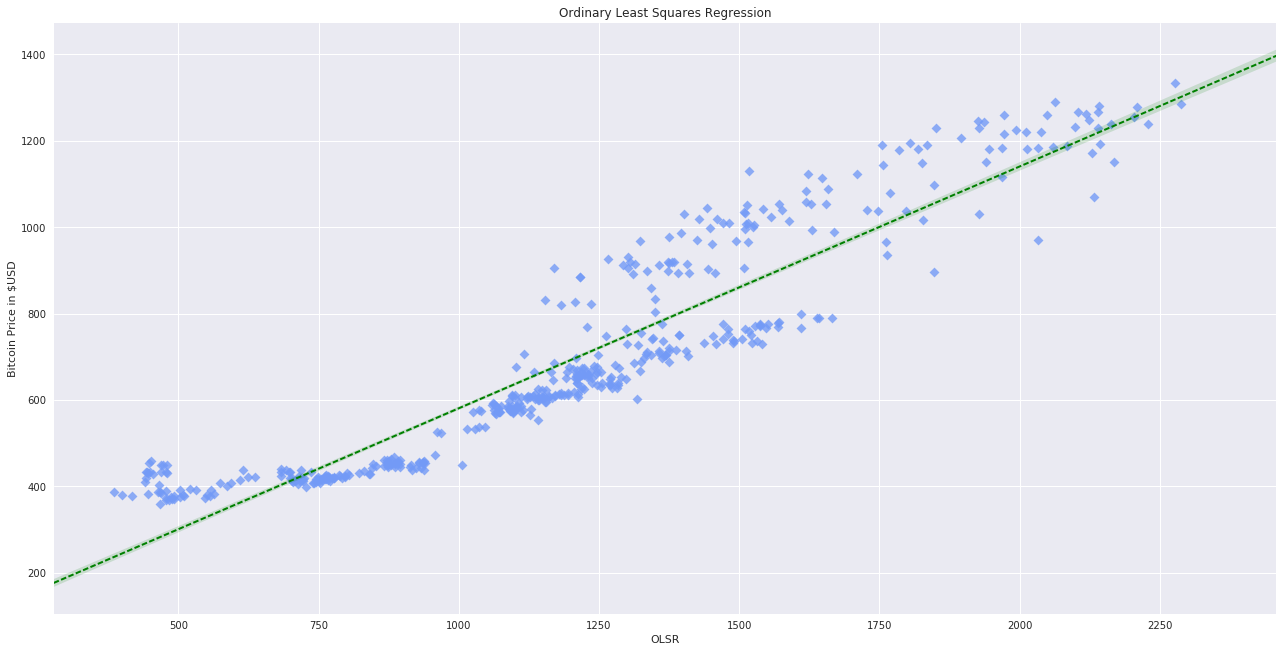

In [116]:
sns.lmplot('OLSR', 'GroundTruth_BTC_USD', daily_predicts_fcasts, size=9, aspect=2, scatter_kws={"color": "#739AF7"}, 
           line_kws={"linewidth": 2, "linestyle":'--', "color": "green"},
           markers='D', 
           ci=68)
plt.xlabel('OLSR')
plt.ylabel('Bitcoin Price in $USD')
plt.legend(loc='upper_left')
plt.title('Ordinary Least Squares Regression')
plt.show();


*** Ordinary Least Squares Absolute Errors in $ USD ******

count     479.000000
mean      502.755439
std       207.429417
min         0.520000
25%       395.270000
50%       516.730000
75%       615.225000
max      1063.040000
Name: OLSR_ERR, dtype: float64


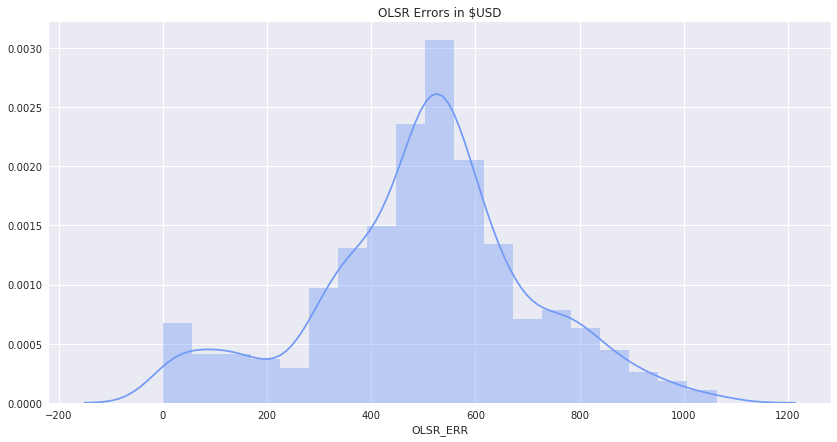

In [121]:
print '\n*** Ordinary Least Squares Absolute Errors in $ USD ******\n'
print pd.Series(daily_errs.OLSR_ERR).describe()

plt.figure(figsize=(14,7))
plt.xlabel('OLSR Prediction Errors +/- $USD')
plt.title('OLSR Errors in $USD')
sns.distplot(daily_errs.OLSR_ERR, color='#739AF7');

#### <font color='purple'>Ridge Regression</font>

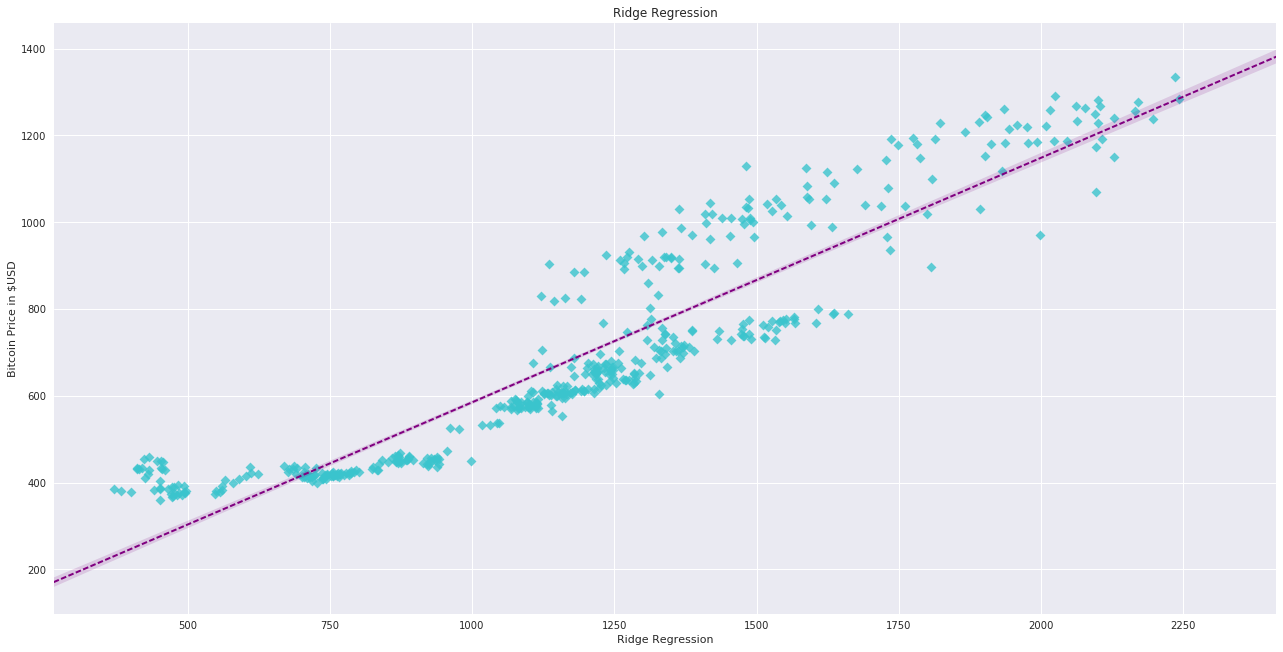

In [82]:
sns.lmplot('Ridge', 'GroundTruth_BTC_USD', daily_predicts_fcasts, size=9, aspect=2, scatter_kws={"color": "#3AC4CD"}, 
           line_kws={"linewidth": 2, "linestyle":'--', "color": "purple"},
           markers='D', 
           ci=68)
plt.xlabel('Ridge Regression')
plt.ylabel('Bitcoin Price in $USD')
plt.legend(loc='upper_left')
plt.title('Ridge Regression')
plt.show();


*** Ridge Regression Absolute Errors in $ USD ******

count     479.000000
mean      494.565982
std       205.032146
min         2.220000
25%       371.200000
50%       519.530000
75%       607.915000
max      1027.840000
Name: RDGE_ERR, dtype: float64


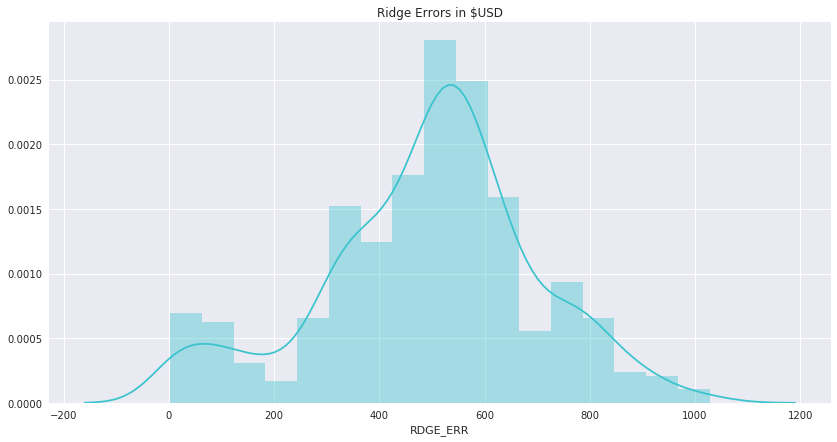

In [124]:
print '\n*** Ridge Regression Absolute Errors in $ USD ******\n'
print pd.Series(daily_errs.RDGE_ERR).describe()

plt.figure(figsize=(14,7))
plt.xlabel('Ridge Prediction Errors +/- $USD')
plt.title('Ridge Errors in $USD')
sns.distplot(daily_errs.RDGE_ERR, color='#3AC4CD');

#### <font color='#40C039'>Lasso Regression</font>

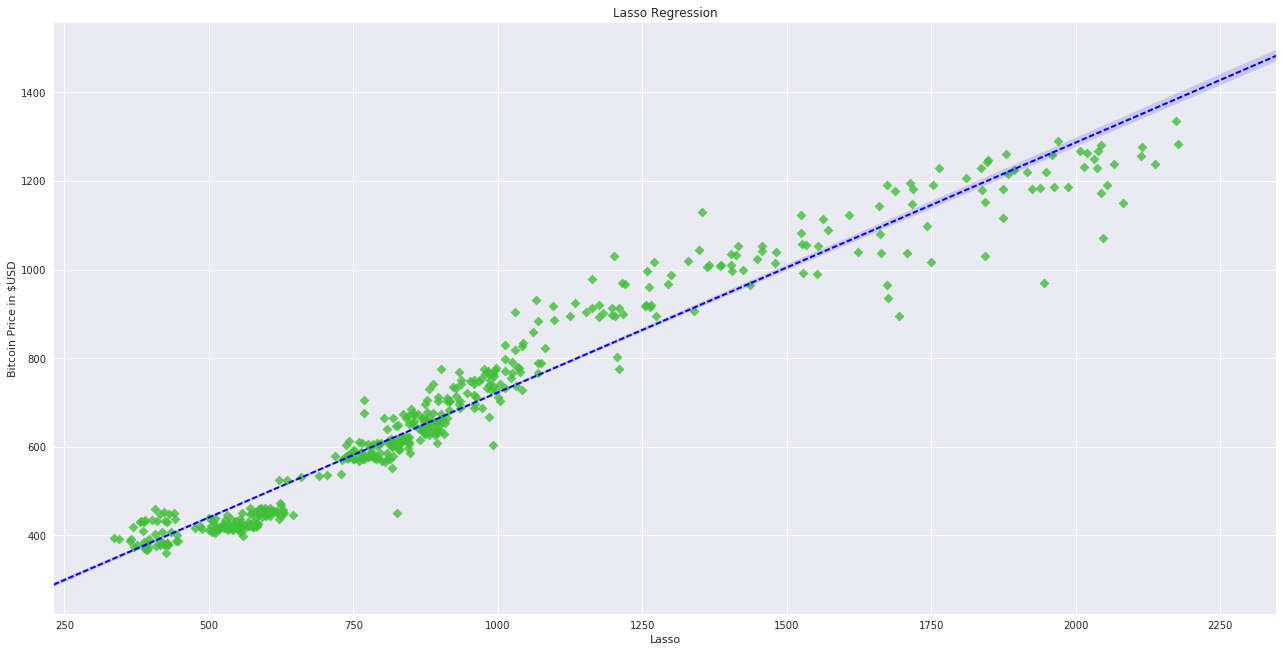

In [73]:
sns.lmplot('Lasso', 'GroundTruth_BTC_USD', daily_predicts_fcasts, size=9, aspect=2, scatter_kws={"color": "#40C039"}, 
           line_kws={"linewidth": 2, "linestyle":'--', "color": "blue"},
           markers='D', 
           ci=68)
plt.xlabel('Lasso')
plt.ylabel('Bitcoin Price in $USD')
plt.legend(loc='upper_left')
plt.title('Lasso Regression')
plt.show();


*** Lasso Regression Absolute Errors in $ USD ******

count    479.000000
mean     253.229615
std      196.516586
min        2.240000
25%      140.170000
50%      208.980000
75%      266.595000
max      977.180000
Name: LSSO_ERR, dtype: float64


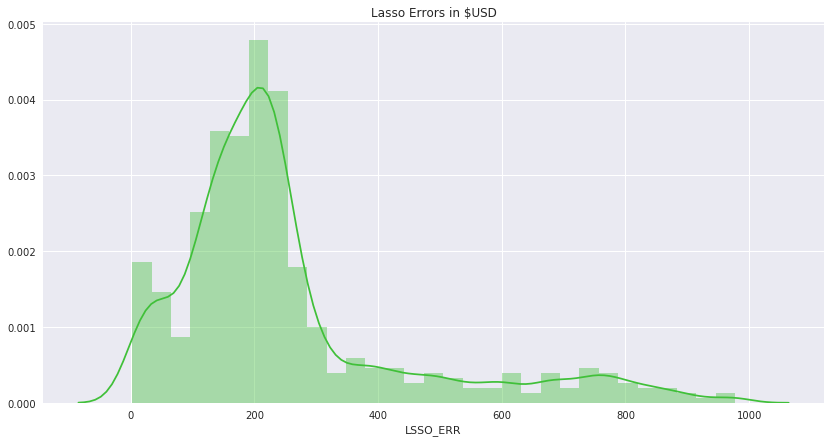

In [125]:
print '\n*** Lasso Regression Absolute Errors in $ USD ******\n'
print pd.Series(daily_errs.LSSO_ERR).describe()

plt.figure(figsize=(14,7))
plt.xlabel('Lasso Prediction Errors +/- $USD')
plt.title('Lasso Errors in $USD')
sns.distplot(daily_errs.LSSO_ERR, color='#40C039');

#### <font color='#495695'>LassoCV Regression</font>

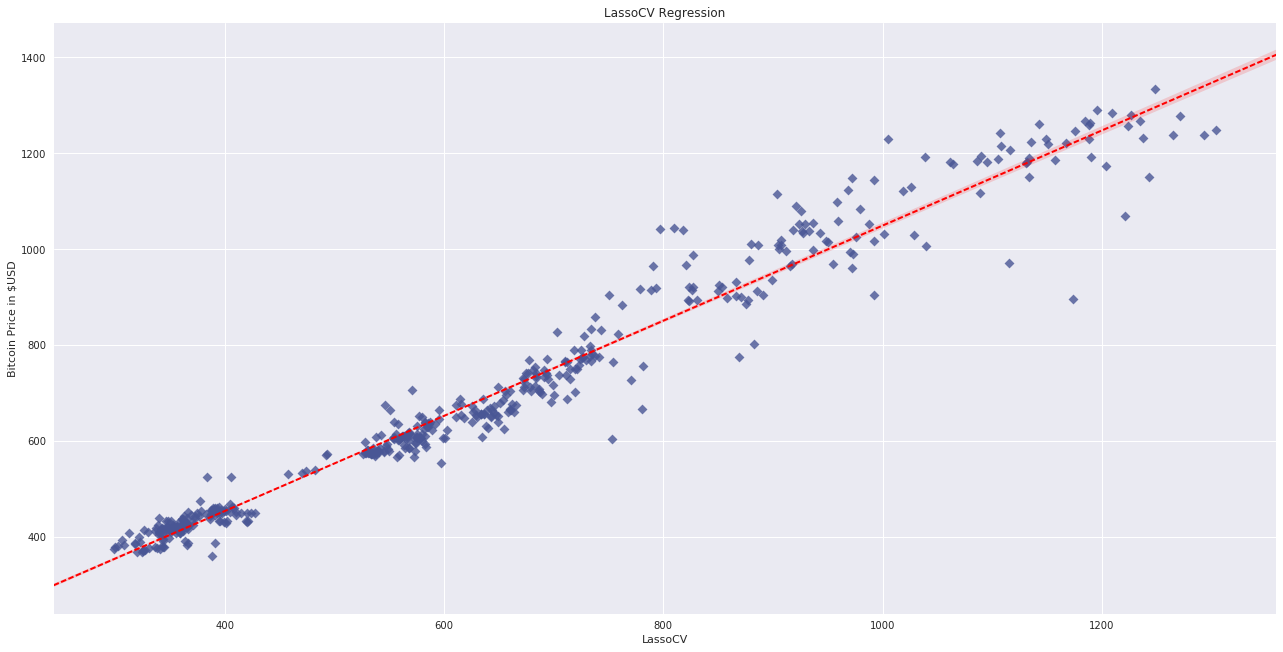

In [83]:
sns.lmplot('LassoCV', 'GroundTruth_BTC_USD', daily_predicts_fcasts, size=9, aspect=2, scatter_kws={"color": "#495695"}, 
           line_kws={"linewidth": 2, "linestyle":'--', "color": "red"},
           markers='D', 
           ci=68)
plt.xlabel('LassoCV')
plt.ylabel('Bitcoin Price in $USD')
plt.legend(loc='upper_left')
plt.title('LassoCV Regression')
plt.show();


*** LassoCV Regression Absolute Errors in $ USD ******

count    479.000000
mean     253.229615
std      196.516586
min        2.240000
25%      140.170000
50%      208.980000
75%      266.595000
max      977.180000
Name: LSSO_ERR, dtype: float64


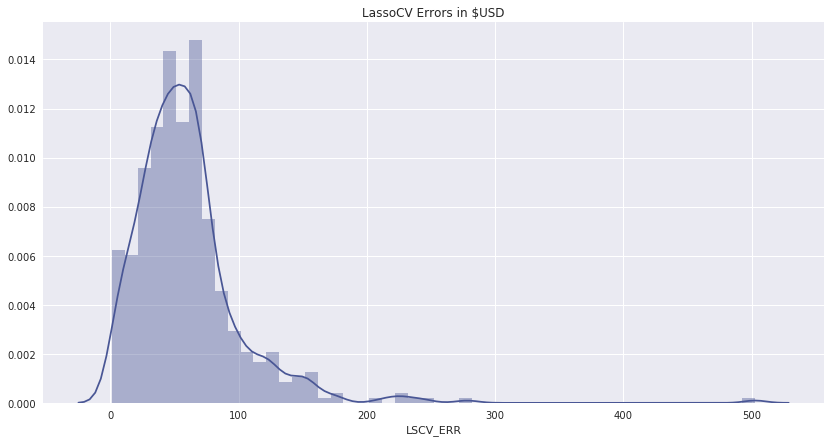

In [127]:
print '\n*** LassoCV Regression Absolute Errors in $ USD ******\n'
print pd.Series(daily_errs.LSSO_ERR).describe()

plt.figure(figsize=(14,7))
plt.xlabel('LassoCV Prediction Errors +/- $USD')
plt.title('LassoCV Errors in $USD')
sns.distplot(daily_errs.LSCV_ERR, color='#495695');

#### <font color='#3A7BCD'>Prophet Time Series Forecast</font>

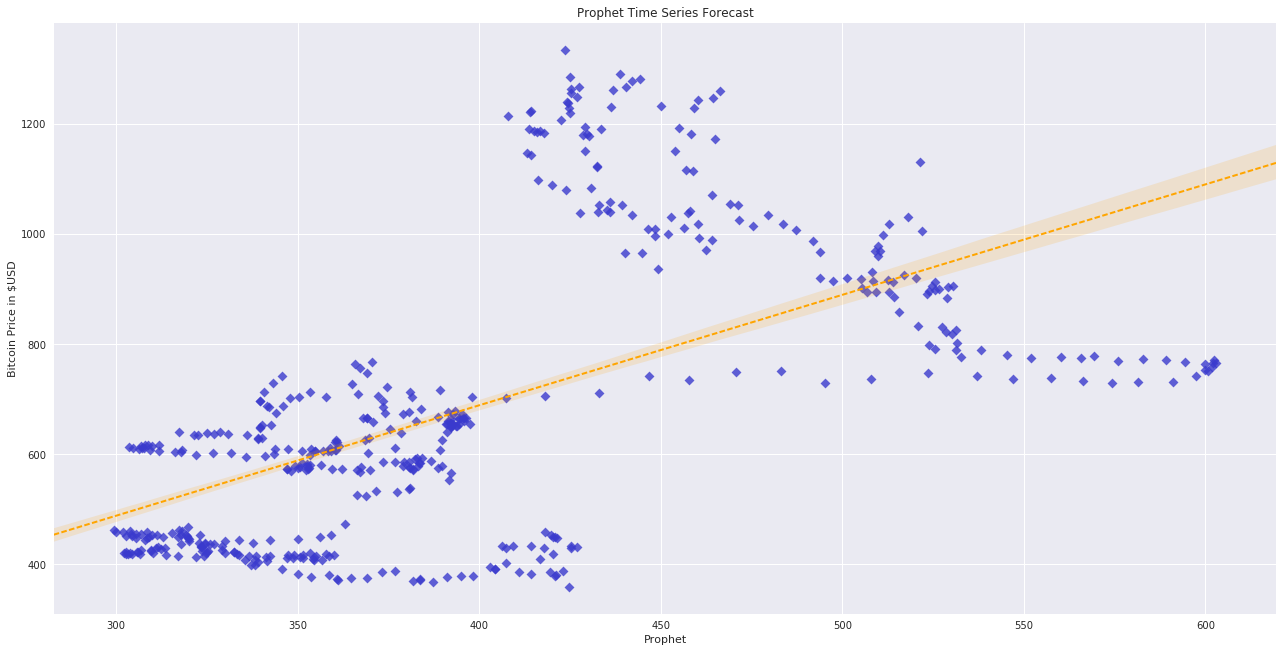

In [86]:
sns.lmplot('Prophet', 'GroundTruth_BTC_USD', daily_predicts_fcasts, size=9, aspect=2, scatter_kws={"color": "#3A3ACD"}, 
           line_kws={"linewidth": 2, "linestyle":'--', "color": "orange"},
           markers='D', 
           ci=68)
plt.xlabel('Prophet')
plt.ylabel('Bitcoin Price in $USD')
plt.legend(loc='upper_left')
plt.title('Prophet Time Series Forecast')
plt.show();


*** Prophet Regression Absolute Errors in $ USD ******

count    479.000000
mean     253.229615
std      196.516586
min        2.240000
25%      140.170000
50%      208.980000
75%      266.595000
max      977.180000
Name: LSSO_ERR, dtype: float64


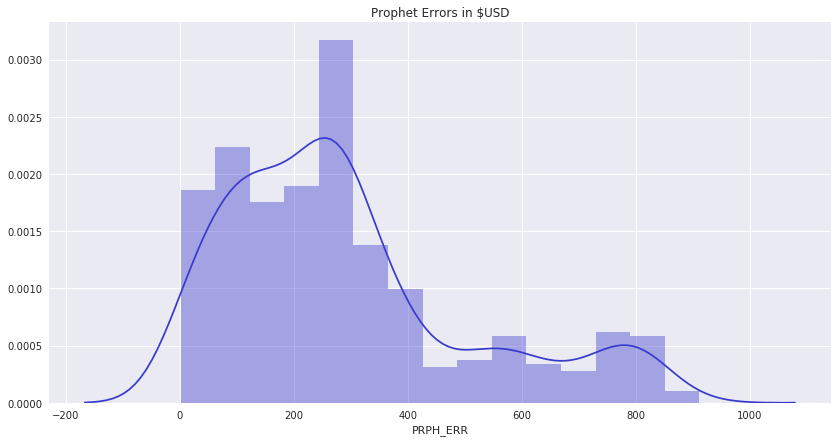

In [133]:
print '\n*** Prophet Regression Absolute Errors in $ USD ******\n'
print pd.Series(daily_errs.LSSO_ERR).describe()

plt.figure(figsize=(14,7))
plt.xlabel('Prophet Errors +/- $USD')
plt.title('Prophet Errors in $USD')
sns.distplot(daily_errs.PRPH_ERR, color='#3A3ACD');

#### <font color='#EF45D8'>Ensemble</font>

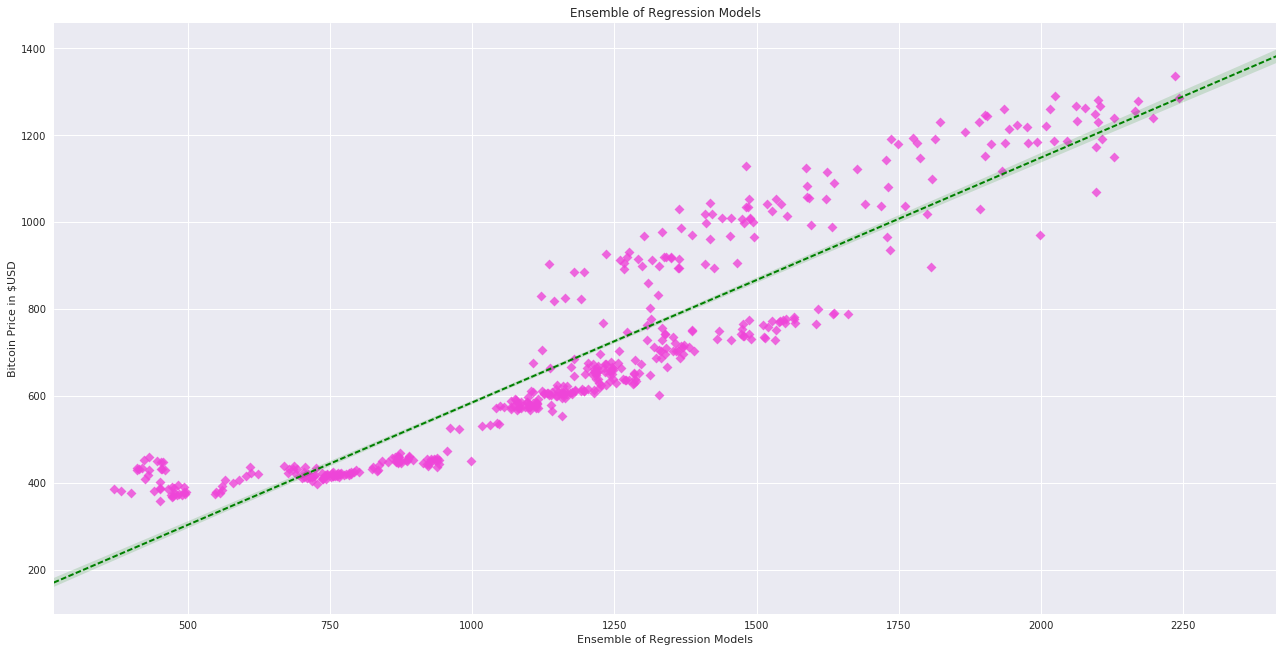

In [109]:
sns.lmplot('Ridge', 'GroundTruth_BTC_USD', daily_predicts_fcasts, size=9, aspect=2, scatter_kws={"color": "#EF45D8"}, 
           line_kws={"linewidth": 2, "linestyle":'--', "color": "green"},
           markers='D', 
           ci=68)
plt.xlabel('Ensemble of Regression Models')
plt.ylabel('Bitcoin Price in $USD')
plt.legend(loc='upper_left')
plt.title('Ensemble of Regression Models')
plt.show();


*** Ensemble (Mean of Regression Models) Absolute Errors in $ USD ******

count    479.000000
mean     253.229615
std      196.516586
min        2.240000
25%      140.170000
50%      208.980000
75%      266.595000
max      977.180000
Name: LSSO_ERR, dtype: float64


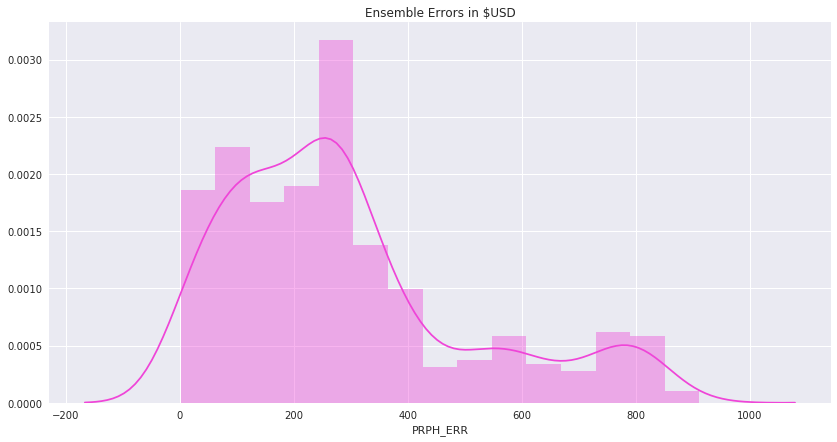

In [135]:
print '\n*** Ensemble (Mean of Regression Models) Absolute Errors in $ USD ******\n'
print pd.Series(daily_errs.LSSO_ERR).describe()

plt.figure(figsize=(14,7))
plt.xlabel('Ensemble Prediction Errors +/- $USD')
plt.title('Ensemble Errors in $USD')
sns.distplot(daily_errs.PRPH_ERR, color='#EF45D8');

### <font color='#4C6FF3'>Buy and Sell Orders and Bitcoin Price Index</font>

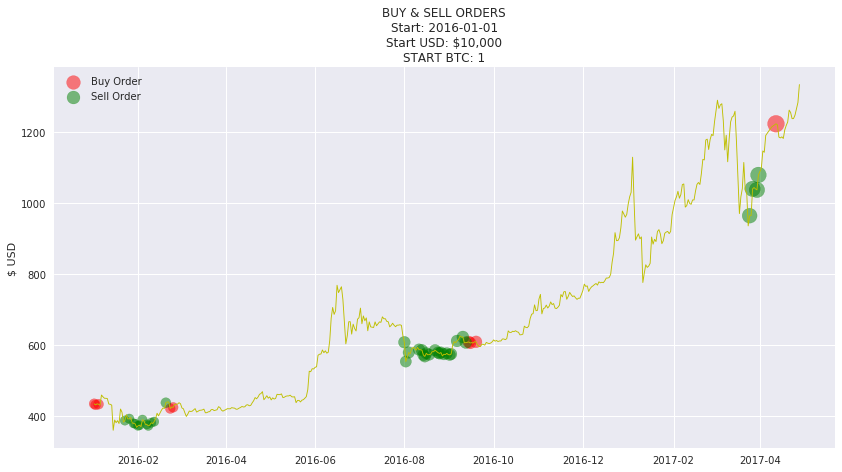

In [56]:
plt.figure(figsize=(14,7))
dp = plt.plot(daily_predicts_fcasts.index, daily_predicts_fcasts['GroundTruth_BTC_USD'], linewidth=0.9, color='y')
bo = plt.scatter(y=buy_orders.values, x=buy_orders.index, color='red', alpha=0.5, s=buy_orders*0.23) 
so = plt.scatter(y=sell_orders.values, x=sell_orders.index, color='green', alpha=0.5, s=sell_orders*0.23) 
plt.ylabel('$ USD')
plt.legend((dp, bo, so), ('Bitcoin-USD Price', 'Buy Order', 'Sell Order'), loc='upper left')
plt.title('BUY & SELL ORDERS\nStart: {}\nStart USD: $10,000\nSTART BTC: 1'.format('2016-01-01'))
plt.show();

In [96]:
X_train_test_df.tail(2)

,NxtDayBTC_USD_ToPredict,tot_blkchn_size,avg_blk_size,tot_output_vol,hash_rate_btc,miners_rev,difficulty,timestp,tot_BTCs,btc_mkt_cap,...,avg_trans_conf_time,tot_trans_fees_btc,tot_trans_fees_usd,cost_per_trans,cost_as_perct_vol,btc_usd_lag1,btc_usd_lag2,btc_usd_lag3,btc_usd_lag4,btc_usd_lag5
2017-04-26,1284.3488,112487.432163,0.966010,3.246840e+06,3.831652e+06,2.615124e+06,5.208087e+11,2017-04-27 02:42:02,16293862.5,2.084661e+10,...,24.675,271.627384,347524.065013,8.342193,0.691852,1248.7925,1238.9325,1238.8038,1256.0875,1262.8260
2017-04-27,NaN,112636.125960,0.971855,2.429754e+06,3.961100e+06,2.740622e+06,5.208087e+11,2017-04-28 02:42:03,16295775.0,2.133296e+10,...,17.975,253.843678,332309.265118,8.479007,0.757251,1267.1988,1248.7925,1238.9325,1238.8038,1256.0875


In [97]:
mean_abs_errs

{'Ensemble': 301.554121338912,
 'Lasso': 251.48119496855344,
 'LassoCV': 58.87134171907755,
 'OLSR': 501.83563941299747,
 'Prophet': 288.20989517819703,
 'Prophet_Lo': 752.5229559748426,
 'Prophet_Up': 240.79811320754698,
 'Ridge': 493.69945492662487}

In [98]:
rmses

{'Ensemble': 301.55412133891201,
 'Lasso': 251.48119496855344,
 'LassoCV': 58.871341719077549,
 'OLSR': 501.83563941299747,
 'Prophet': 288.20989517819703,
 'Prophet_Lo': 752.5229559748426,
 'Prophet_Up': 240.79811320754698,
 'Ridge': 493.69945492662487}

In [99]:
dly_var_BTC_USD.tail()

2016-01-30    5.698588
2017-02-21         NaN
2016-12-24    3.678646
2016-02-11    5.127677
2016-06-09    4.462128
dtype: float64

In [100]:
dailyBTCUSDexch_vol.head()

2016-07-18    2.634661e+07
2016-04-04    1.062613e+07
2017-04-23    4.758998e+07
2016-09-17    1.283670e+07
2016-06-05    4.516819e+07
dtype: float64

### <font color='#4C6FF3'>Moving Averages</font>

In [136]:
emas = get_mov_avgs(short_window=10, long_window=60)
emas.head()

,date,btc_usd_rate,ema_short,ema_long,sma_short,sma_long
1095,2016-01-01,434.463,435.896288,379.858080,433.7279,389.592592
1096,2016-01-02,433.586,434.546753,379.820187,432.8026,390.140587
1097,2016-01-03,430.361,430.748767,379.535230,430.3539,390.500913
1098,2016-01-04,433.493,426.603784,379.844310,428.1720,391.267297
1099,2016-01-05,432.253,428.574234,380.483017,429.6757,392.222347


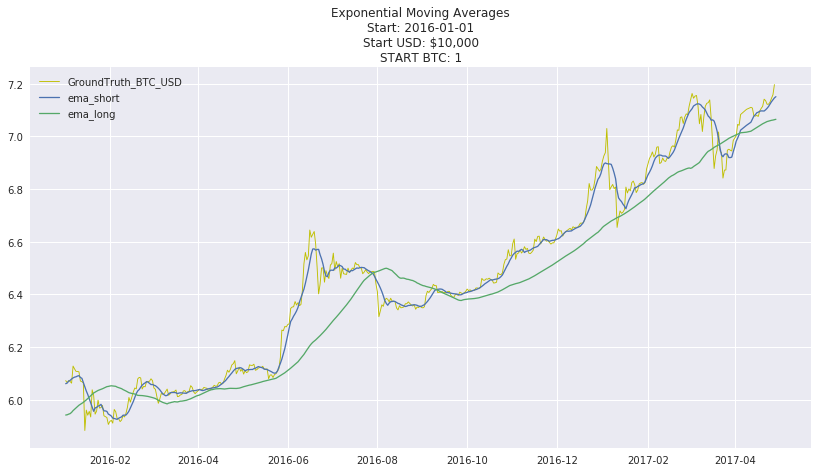

In [148]:
# EMAs and Bitcoin_USD_RATE (Accd'g to the Bitcoin Price Index (BPI))

plt.figure(figsize=(14,7))
plt.plot(daily_predicts_fcasts.index, np.log(daily_predicts_fcasts['GroundTruth_BTC_USD']), linewidth=0.9, color='y')
plt.plot(daily_predicts_fcasts.index, np.log(emas[emas.date > '2016-01-04'].ema_short), linewidth=1.3)
plt.plot(daily_predicts_fcasts.index, np.log(emas[emas.date > '2016-01-04'].ema_long), linewidth=1.3)

plt.legend(loc='upper left')
plt.title('Exponential Moving Averages\nStart: {}\nStart USD: $10,000\nSTART BTC: 1'.format('2016-01-01'))
plt.show();